### TODOs
[ ] Load SAM3 as a model
[ ] Gemini / OpenAI API support

In [75]:
# Go to sam3 root dir
%cd ~/code/sam3

/storage/home/jialez/code/sam3


In [109]:
from pathlib import Path
from typing import List

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgb
import pycocotools.mask as mask_utils


from sam3 import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.agent.helpers.mask_overlap_removal import remove_overlapping_masks
from sam3.agent.viz import visualize



In [77]:
LLM_CONFIGS = {
    # VLLM-served models
    "qwen2.5_7b": {
        "provider": "vllm",
        "model": "Qwen/Qwen2.5-VL-7B-Instruct",
    },
    "qwen2.5_72b": {
        "provider": "vllm",
        "model": "Qwen/Qwen2.5-VL-72B-Instruct",
    },
    "qwen3_235b": {
        "provider": "vllm",
        "model": "Qwen/Qwen3-VL-235B-A22B-Instruct",
    },
    "llama4_maverick": {
        "provider": "vllm",
        "model": "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
    },
    "llama4_scout": {
        "provider": "vllm",
        "model": "meta-llama/Llama-4-Scout-17B-16E-Instruct",
    },
    "gpt5": {
        "provider": "openai",
        "base_url": "https://api.openai.com/v1/",
        "model": "gpt-5",
    },
    "gemini_pro": {
        "provider": "gemini",
        "base_url": "https://generativelanguage.googleapis.com/v1beta/",
        "model": "gemini-2.5-pro",
    },
    "gemini_flash": {
        "provider": "gemini",
        "base_url": "https://generativelanguage.googleapis.com/v1beta/",
        "model": "gemini-2.5-flash",
    }
}

model = "qwen2.5_7b" # @param ["qwen2.5_7b,"qwen2.5_72b","llama4_maverick","llama4_scout","gpt5","gemini_pro","gemini_flash"] {"allow-input":true}
LLM_API_KEY = "DUMMY_API_KEY" # @param ["DUMMY_API_KEY"]

#model = "gpt5"
#LLM_API_KEY = "YOUR_OPENAI_API_KEY"

#model = "gemini_pro"
#LLM_API_KEY = "YOUR_GEMINI_API_KEY"


llm_config = LLM_CONFIGS[model]
llm_config["api_key"] = LLM_API_KEY
llm_config["name"] = model

In [98]:
# Start LLM server, skip this step if you are calling LLM using an API

# qwen 2.5VL 7B
# vllm serve Qwen/Qwen2.5-VL-7B-Instruct --tensor-parallel-size 1 --allowed-local-media-path / --enforce-eager --port 8001

# qwen 2.5VL 72B
#vllm serve Qwen/Qwen2.5-VL-72B-Instruct --tensor-parallel-size 8 --allowed-local-media-path / --enforce-eager --port 8001

# Llama 4 Maverick
# VLLM_DISABLE_COMPILE_CACHE=1 vllm serve meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8   --tensor-parallel-size 8   --max-model-len 430000 --allowed-local-media-path / --port 8001

# Llama 4 Scout
# VLLM_DISABLE_COMPILE_CACHE=1 vllm serve meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8   --tensor-parallel-size 4   --max-model-len 30000 --allowed-local-media-path / --max-num-seqs 1 --port 8001

if llm_config["provider"] == "vllm":
    #LLM_SERVER_URL = "http://localhost:8001/v1"
    LLM_SERVER_URL = "http://h200-017-014:8001/v1" # TODO replace this with default LLM url
else:
    LLM_SERVER_URL = llm_config["base_url"]


# Build SAM3 Model

In [79]:

# Get the home directory
home_dir = Path.home()
# Construct the path to $HOME/me
me_path = home_dir / "me" / "code"
print(me_path)
sam3_root = Path.home() / "code" / "sam3"
bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"


/home/jialez/me/code


In [81]:
sam3_root = Path.home() / "code" / "sam3"

bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"

# checkpoint_path = f"{sam3_root}/assets/checkpoints/sam3_prod_v12_interactive_5box_image_only.pt"

checkpoint_path = f"{sam3_root}/assets/checkpoints/checkpoint.pt"
has_presence_token = True

model = build_sam3_image_model(bpe_path=bpe_path, checkpoint_path=checkpoint_path, has_presence_token=has_presence_token)
processor = Sam3Processor()


In [88]:
def sam3_inference(model, processor, image_path, prompt):
    image = Image.open(image_path)
    inference_state = processor(image, instance_prompt=False)
    #processor.reset_state(inference_state)
    processor.add_prompt(inference_state, text_str=prompt,  instance_prompt=False)
    model.run_inference(inference_state )
    out = processor.postprocess_output(inference_state ,output_prob_thresh=0.5)

    orig_img_w, orig_img_h = image.size

    pred_masks = rle_encode(torch.from_numpy(out['out_binary_masks']))
    pred_masks = [m['counts'] for m in pred_masks]
    
    outputs = {
        "orig_img_h": orig_img_h,
        "orig_img_w": orig_img_w,
        "pred_boxes": out['out_boxes_xywh'].tolist(),
        "pred_masks": pred_masks, #out['out_binary_masks'], # TODO convert to RLE mask
        "pred_scores": out['out_probs'].tolist(),
        #"out_binary_masks": out["out_binary_masks"],
    }

    return outputs

In [89]:
sam3_inference(model, processor, image_path, 'shoe')


{'orig_img_h': 720,
 'orig_img_w': 1280,
 'pred_boxes': [[0.5067293047904968,
   0.7850791811943054,
   0.02356576919555664,
   0.04763984680175781],
  [0.7946429252624512,
   0.7705254554748535,
   0.03516817092895508,
   0.044944047927856445],
  [0.4737205505371094,
   0.8293290734291077,
   0.02745133638381958,
   0.03201949596405029],
  [0.28342998027801514,
   0.8483332395553589,
   0.047518014907836914,
   0.054773807525634766],
  [0.33700031042099,
   0.8645871877670288,
   0.050341904163360596,
   0.0506742000579834],
  [0.4571688175201416,
   0.8064660429954529,
   0.027543485164642334,
   0.026964187622070312],
  [0.7347074747085571,
   0.7656489610671997,
   0.03181159496307373,
   0.04003417491912842],
  [0.3902781903743744,
   0.8278056979179382,
   0.04012268781661987,
   0.03827047348022461],
  [0.7003824710845947,
   0.7869642972946167,
   0.024300694465637207,
   0.04211103916168213],
  [0.5677852630615234,
   0.7991296648979187,
   0.03971576690673828,
   0.0382336378

In [110]:
def call_sam_service(image_path: str, text_prompt: str, output_folder_path: str = "sam3_output", threshold: float = 0.5, selected_masks: List[int]=None):
    """
    Loads an image, sends it with a text prompt to the service,
    saves the results, and renders the visualization.
    """
    print(f"📞 Loading image '{image_path}' and sending with prompt '{text_prompt}'...")
    
    text_prompt_for_save_path = text_prompt.replace("/", "_") if "/" in text_prompt else text_prompt
    
    os.makedirs(os.path.join(output_folder_path, image_path.replace("/", "-")), exist_ok=True)
    output_json_path = os.path.join(output_folder_path, image_path.replace("/", "-"), rf"{text_prompt_for_save_path}.json")
    output_image_path = os.path.join(output_folder_path, image_path.replace("/", "-"), rf"{text_prompt_for_save_path}.png")


    #try:
    # Send the image and text prompt as a multipart/form-data request
    #with open(image_path, "rb") as f:
    #    data = {'image_path': image_path, 'find_input_text': text_prompt, 'threshold': threshold}
        #response = requests.post(server_url, data=data)

    #response.raise_for_status()
    serialized_response = sam3_inference(model, processor, image_path, text_prompt)
    
    # 1. Get the raw JSON response from SAM3 Server
    #serialized_response = response.json()
    
    # add remove duplicate masks
    serialized_response = remove_overlapping_masks(serialized_response)
    serialized_response = {"original_image_path": image_path, **serialized_response}
    serialized_response = {"output_image_path": output_image_path, **serialized_response}
    

    # 2. Reorder predictions by scores (highest to lowest) if scores are available
    if 'pred_scores' in serialized_response and serialized_response['pred_scores']:
        # Create indices sorted by scores in descending order
        score_indices = sorted(range(len(serialized_response['pred_scores'])), 
                             key=lambda i: serialized_response['pred_scores'][i], reverse=True)
        
        # Reorder all three lists based on the sorted indices
        serialized_response['pred_scores'] = [serialized_response['pred_scores'][i] for i in score_indices]
        serialized_response['pred_boxes'] = [serialized_response['pred_boxes'][i] for i in score_indices]
        serialized_response['pred_masks'] = [serialized_response['pred_masks'][i] for i in score_indices]
    
    # 3. Remove any invalid RLE masks that is too short (shorter than 5 characters)
    valid_masks = []
    valid_boxes = []
    valid_scores = []
    for i, rle in enumerate(serialized_response['pred_masks']):
        if len(rle) > 4:
            valid_masks.append(rle)
            valid_boxes.append(serialized_response['pred_boxes'][i])
            valid_scores.append(serialized_response['pred_scores'][i])
    serialized_response['pred_masks'] = valid_masks
    serialized_response['pred_boxes'] = valid_boxes
    serialized_response['pred_scores'] = valid_scores

    with open(output_json_path, 'w') as f:
        json.dump(serialized_response, f, indent=4)
    print(f"✅ Raw JSON response saved to '{output_json_path}'")
    
    
    # 4. Render and save visualizations on the image and save it in the SAM3 output folder
    print("🔍 Rendering visualizations on the image...")
    # pil_image = np.array(Image.open(image_path).convert('RGB'))
    cv2_img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    boxes_array = np.array(serialized_response['pred_boxes'])
    coco_rle_masks = [{'size': (serialized_response["orig_img_h"], serialized_response["orig_img_w"]), 'counts': rle} for rle in serialized_response['pred_masks']]
    binary_masks = [mask_utils.decode(i) for i in coco_rle_masks]
    viz_image = visualize(cv2_img, boxes_array, coco_rle_masks, binary_masks)
    os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
    viz_image.save(output_image_path)
    print("✅ Saved visualization at:", output_image_path)

    #except Exception as e:
    #    print(f"❌ Error calling service: {e}")
    
    return output_json_path

In [2]:
# Start SAM3 server

SAM3_SERVICE_URL = "http://h200-235-192:8000/segment"


In [111]:
# Import dependencies
import os
import json
from functools import partial


from sam3.agent.agent_core import agent_inference
from sam3.agent.client_llm import send_generate_request as send_generate_request_orig
#from sam3.agent.client_sam3 import call_sam_service as call_sam_service_orig

In [112]:
def run_single_image_inference(image_path, text_prompt, llm_config, send_generate_request, call_sam_service, output_dir="agent_output"):
    """Run inference on a single image with provided prompt"""

    llm_name = llm_config["name"]

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Generate output file names
    image_basename = os.path.splitext(os.path.basename(image_path))[0]
    prompt_for_filename = text_prompt.replace("/", "_").replace(" ", "_")

    base_filename = f"{image_basename}_{prompt_for_filename}_Agent_{llm_name}"
    output_json_path = os.path.join(output_dir, f"{base_filename}_Pred.json")
    output_image_path = os.path.join(output_dir, f"{base_filename}_Pred.png")
    agent_history_path = os.path.join(output_dir, f"{base_filename}_History.json")

    # Check if output already exists and skip
    if os.path.exists(output_json_path):
        print(f"Output JSON {output_json_path} already exists. Skipping.")
        return

    print(f"\n\n\n--------------Processing single image with prompt: {text_prompt}--------------\n")
    print(f"Image: {image_path}")
    print(f"Output directory: {output_dir}")

    #try:
    agent_history, final_output_dict, rendered_final_output = agent_inference(
        image_path, text_prompt,
        send_generate_request=send_generate_request,
        call_sam_service=call_sam_service
    )

    final_output_dict["text_prompt"] = text_prompt
    final_output_dict["image_path"] = image_path

    # Save outputs
    json.dump(final_output_dict, open(output_json_path, 'w'), indent=4)
    json.dump(agent_history, open(agent_history_path, 'w'), indent=4)
    rendered_final_output.save(output_image_path)

    print(f"\n✅ Successfully processed single image!")
    print(f"Output JSON: {output_json_path}")
    print(f"Output Image: {output_image_path}")
    print(f"Agent History: {agent_history_path}")




--------------Processing single image with prompt: People wearing blue clothes--------------

Image: /storage/home/jialez/code/sam3/assets/images/test_image.jpg
Output directory: agent_output

Initial text prompt:

 People wearing blue clothes


Initial image path:

 /storage/home/jialez/code/sam3/assets/images/test_image.jpg
image_path /storage/home/jialez/code/sam3/assets/images/test_image.jpg
processed_messages: [{'role': 'system', 'content': 'You are a helpful visual-concept grounding assistant capable of leveraging tool calls to ground concepts the user refers to, and providing structured JSON outputs and tool calls.\nThe user may provide you with a referring expression that matches some part(s) of the image, or a question whose answer points to some part(s) of the image.\nYou should observe and analyze the image along with the initial user input query very carefully, note all details in the image, think about what the user is actually referring to, how to leverage existing too
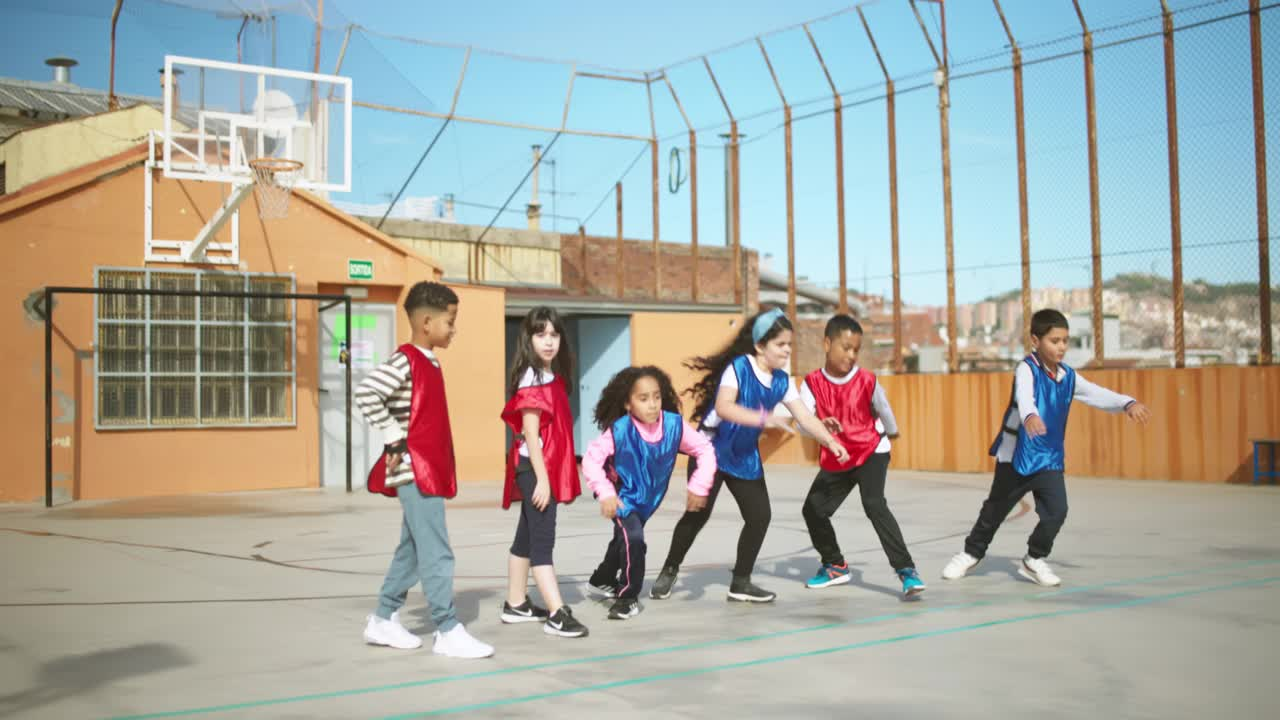
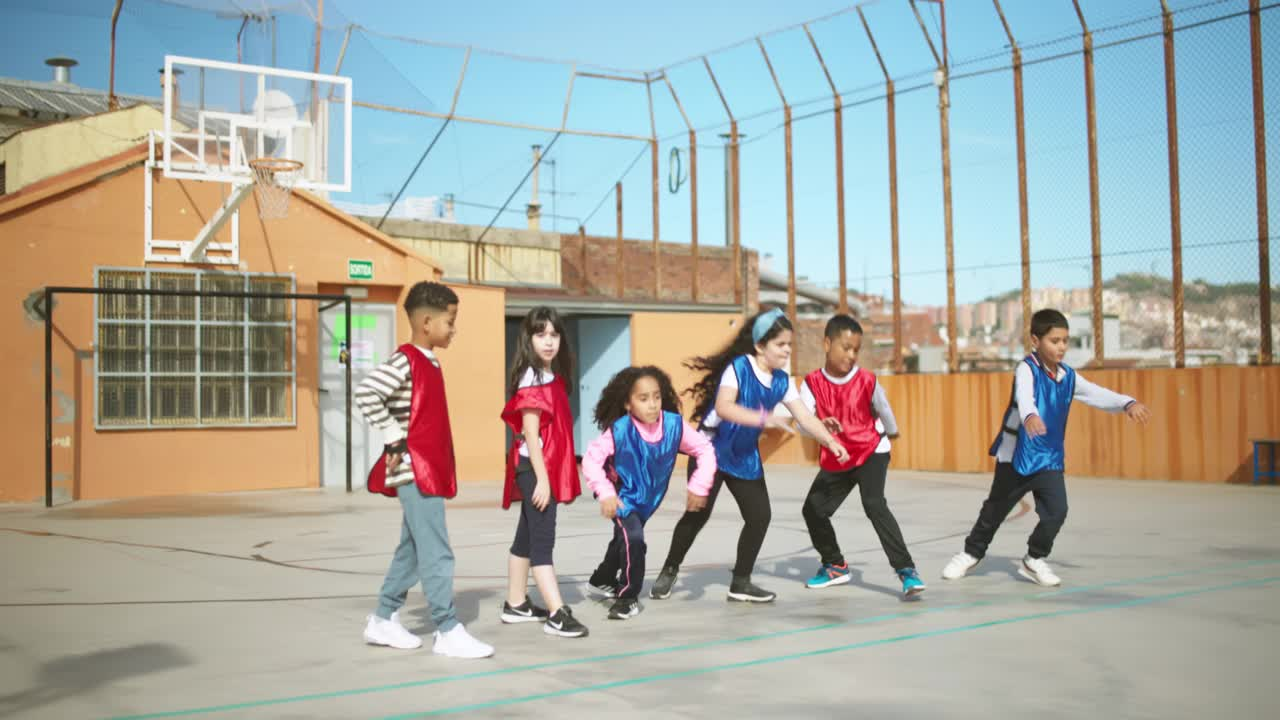
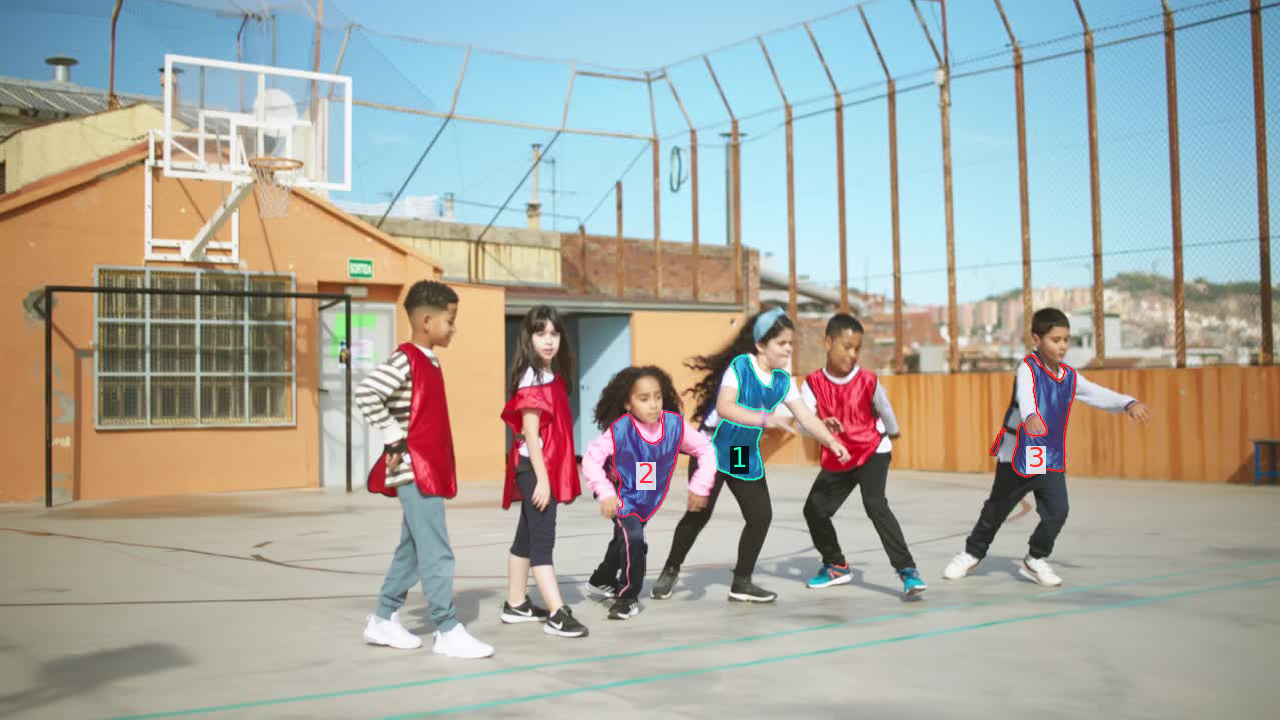

In [113]:
image = "assets/images/test_image.jpg"
prompt = "People wearing blue clothes"

# get absolute path for image
image = os.path.abspath(image)
send_generate_request = partial(send_generate_request_orig, server_url=LLM_SERVER_URL, model=llm_config["model"], api_key=llm_config["api_key"])
#call_sam_service = partial(call_sam_service_orig, server_url=SAM3_SERVICE_URL)

# Run single image inference
run_single_image_inference(image, prompt, llm_config, send_generate_request, call_sam_service)

In [107]:
!rm -r agent_output